<a href="https://colab.research.google.com/github/hanokjoshua144/Machine-Learning/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install & Import Libraries → Make sure xgboost and imbalanced-learn are available, import core ML + plotting libraries.**

In [ ]:
!pip install xgboost scikit-learn imbalanced-learn

In [ ]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# ML Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


**Load Dataset → Download the Pima Indians Diabetes dataset, assign feature names.**

In [ ]:
# Load the Pima Indians Diabetes dataset (from UCI repository)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Define column names for clarity
columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

# Read into pandas dataframe
df = pd.read_csv(url, names=columns)

print("Dataset Shape:", df.shape)  # Total rows and columns
df.head()  # Display first 5 rows


Dataset Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Preprocessing → Replace invalid zeros with median values, scale features, split train/test**

In [ ]:
# Many medical columns contain '0' which is not realistic (e.g., BMI=0, Glucose=0)
# Replace zeros with NaN, then fill with median values

cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in cols_with_zero:
    df[col] = df[col].replace(0, np.nan)      # Replace 0 with NaN
    df[col] = df[col].fillna(df[col].median())  # Fill missing with median

# Separate features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Normalize features (important for Logistic Regression in stacking)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


**Baseline Models → Train Random Forest, XGBoost, and Stacking with default parameters to get baseline accuracies.**

In [ ]:
# Define three ensemble models:
rf = RandomForestClassifier(random_state=42)   # Bagging
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # Boosting

# Stacking combines RF + XGB with Logistic Regression as meta-learner
stack = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression()
)

# Dictionary of models
models = {'Random Forest': rf, 'XGBoost': xgb, 'Stacking': stack}

# Train and evaluate each baseline model
print("\nBaseline Accuracies:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")


Baseline Accuracies:
Random Forest: 0.779
XGBoost: 0.760
Stacking: 0.773


**Hyperparameter Tuning → Use GridSearchCV to find the best parameters for Random Forest and XGBoost.**

In [ ]:
# Tune Random Forest using GridSearchCV
rf_params = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5,10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("\nBest RF Params:", rf_grid.best_params_)

# Tune XGBoost using GridSearchCV
xgb_params = {
    'n_estimators':[100,200],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,5,7]
}
xgb_grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), xgb_params, cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("\nBest XGB Params:", xgb_grid.best_params_)


Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Best XGB Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Tuned Models Evaluation → Compare tuned vs baseline using Accuracy, ROC-AUC, and classification reports.

In [ ]:
# Extract best models
rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

# Build stacking with tuned models
stack_best = StackingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    final_estimator=LogisticRegression()
)

# Evaluate tuned models
models_tuned = {'RF Tuned': rf_best, 'XGB Tuned': xgb_best, 'Stacking Tuned': stack_best}

for name, model in models_tuned.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(f"\n{name} - Accuracy: {acc:.3f}, ROC-AUC: {roc:.3f}")
    print(classification_report(y_test, y_pred))


RF Tuned - Accuracy: 0.779, ROC-AUC: 0.819
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


XGB Tuned - Accuracy: 0.714, ROC-AUC: 0.809
              precision    recall  f1-score   support

           0       0.73      0.90      0.80       100
           1       0.67      0.37      0.48        54

    accuracy                           0.71       154
   macro avg       0.70      0.64      0.64       154
weighted avg       0.71      0.71      0.69       154


Stacking Tuned - Accuracy: 0.747, ROC-AUC: 0.818
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       100
           1       0.68      0.52      0.59        54

    accuracy                           0.75

Confusion Matrix for tuned Rf

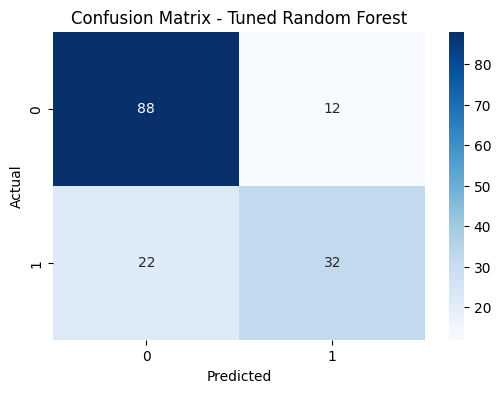

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix for the tuned Random Forest model
y_pred_rf = rf_best.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion Matrix → Plot the confusion matrix for the best model (Stacking).

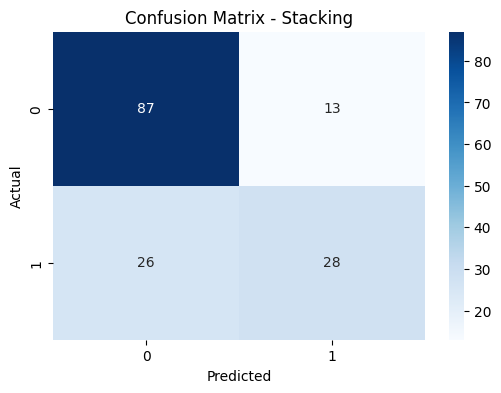

In [ ]:
# Plot confusion matrix for the best model (Stacking)
best_model = stack_best.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Stacking")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Feature Importance → Plot top features based on tuned XGBoost.

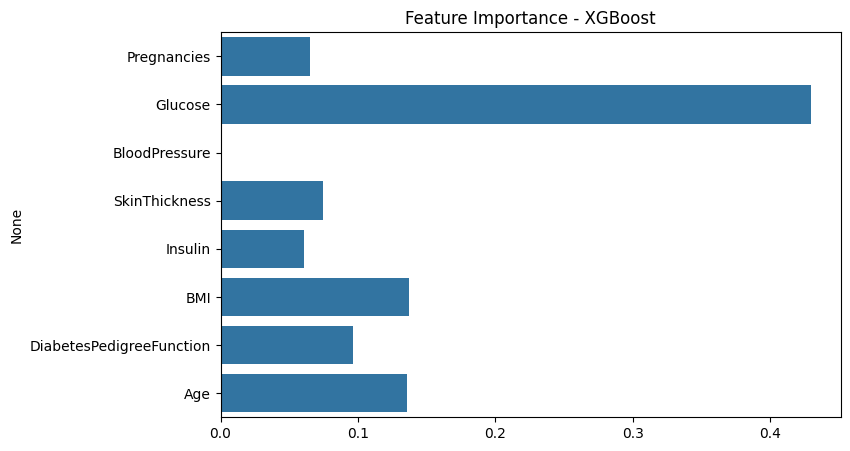

In [ ]:
# Plot feature importance from tuned XGBoost
importances = xgb_best.feature_importances_
features = X.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - XGBoost")
plt.show()

ROC Curve → Plot ROC curve with AUC score for final evaluation.

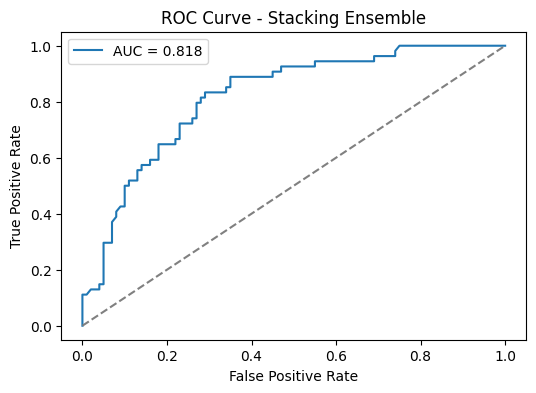

In [ ]:
# Plot ROC Curve for best model (Stacking)
y_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Ensemble")
plt.legend()
plt.show()
